In [1]:

import numpy as np
import pandas as pd
import config as cfg

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

from utility.plot import load_tf_color
TFColor = load_tf_color()

def rename_model_names(df):
    model_name_mapping = {
        'coxph': 'CoxPH',
        'coxboost': 'CoxBoost',
        'rsf': 'RSF',
        'deepsurv': 'DeepSurv',
        'deephit': 'DeepHit',
        'mtlr': 'MTLR',
        'dsm': 'DSM',
        'mensa': 'MENSA (Ours)',
    }
    df['ModelName'] = df['ModelName'].replace(model_name_mapping)
    return df

filename = f"{cfg.RESULTS_DIR}/single_event_dgp.csv"
df = pd.read_csv(filename)
df = df.round(3)

df = df.loc[df['ModelName'] != "dgp"] # exclude dgp

df = rename_model_names(df)

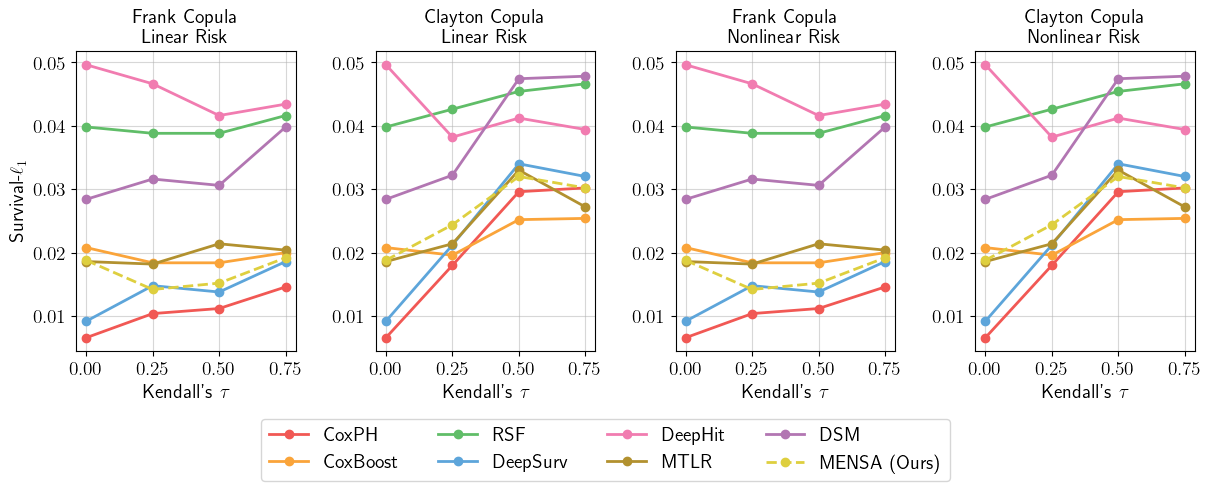

In [16]:
grouped_df = df.groupby(['ModelName', 'KTau', 'Linear', 'Copula'], as_index=False)['L1'].mean()

model_names = ["CoxPH", "CoxBoost", "RSF", "DeepSurv", 'DeepHit', "MTLR", "DSM", "MENSA (Ours)"]

# Create a 1x4 subplot layout
fig, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True,
                        gridspec_kw={'wspace': 0.1})

# Define the specific order of copulas and linearity values
copula_linear_pairs = [
    ('frank', True),      # Frank Copula / Linear Risk
    ('clayton', True),    # Clayton Copula / Linear Risk
    ('frank', False),     # Frank Copula / Nonlinear Risk
    ('clayton', False)    # Clayton Copula / Nonlinear Risk
]

# Store handles and labels for the legend
handles = []
labels = []

# Iterate through each specified combination in the required order
for idx, (copula, linear) in enumerate(copula_linear_pairs):
    # Filter the data for the current copula and linearity
    plot_data = grouped_df[(grouped_df['Copula'] == copula) & (grouped_df['Linear'] == linear)]
    
    # Select the appropriate subplot
    ax = axs[idx]
    
    # Iterate through each unique model name to create separate plots
    for i, model_name in enumerate(model_names):
        model_data = plot_data[plot_data['ModelName'] == model_name]
        
        is_last = (model_name == "MENSA (Ours)")
        
        line, = ax.plot(model_data['KTau'], model_data['L1'],
                        color=TFColor[i], alpha=1,
                        linestyle='-' if not is_last else '--',
                        marker='o', label=model_name,
                        linewidth=2, markersize=6)
        
        # Collect handles and labels for the legend if not already included
        if model_name not in labels:
            handles.append(line)
            labels.append(model_name)
    
    # Set the y-axis and x-axis labels, title, and grid
    ax.set_xlabel(r"Kendall's $\tau$")
    ax.set_title(f"{copula.capitalize()} Copula\n" + ("Linear Risk" if linear else "Nonlinear Risk"))
    ax.grid(True, alpha=0.5)
    ax.set_xticks([0, 0.25, 0.5, 0.75])
    
    if idx == 0:
        ax.set_ylabel(r"Survival-$\ell_{1}$")

# Create a shared legend below the plot
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4)

# Save the figure
fig.savefig(f"{cfg.PLOTS_DIR}/survival_l1.pdf", format='pdf', bbox_inches='tight')